C:\Users\satya\AppData\Local\Temp\ipykernel_17800\2756596337.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


Extracting Data of Class: NonViolence
Extracting Data of Class: Violence
(1800, 16, 71, 71, 3) (1800, 2)
(200, 16, 71, 71, 3) (200, 2)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 3, 3, 2048)   20861480  
 ibuted)                                                         
                                                                 
 dropout (Dropout)           (None, 16, 3, 3, 2048)    0         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 18432)        0         
 tributed)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 64)               4727040   
 l)                                                              
                                                     

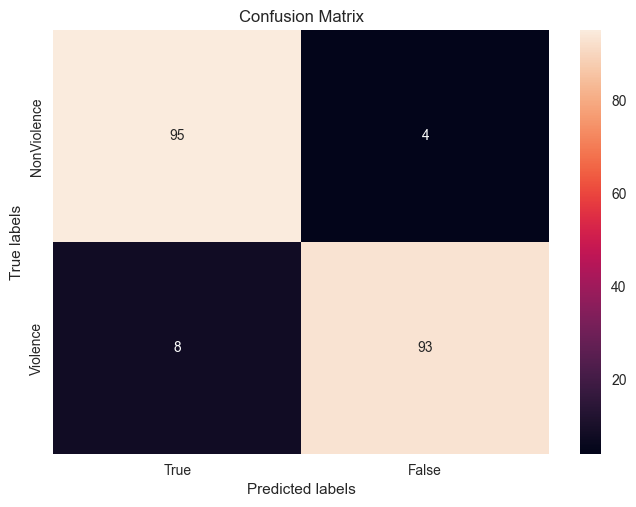

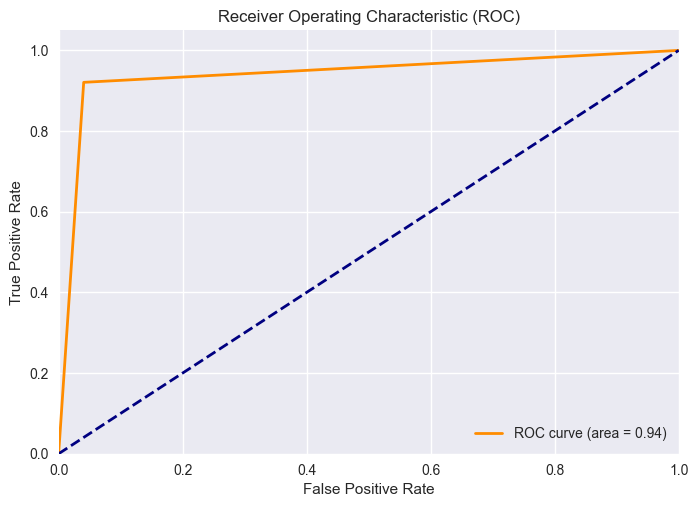

In [1]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from tensorflow import keras
from collections import deque
import matplotlib.pyplot as plt
plt.style.use("seaborn")
%matplotlib inline

from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import HTML
from base64 import b64encode

# To Show a Video in Notebook
def Play_Video(filepath):
    html = ''
    video = open(filepath, 'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    return HTML(html)

# Classes Directories
NonViolenceVideos_Dir = "C://Users//satya//Documents//Violence_Detection//Violence_Dataset_1//Real Life Violence Dataset//NonViolence"
ViolenceVideos_Dir = "C://Users//satya//Documents//Violence_Detection//Violence_Dataset_1//Real Life Violence Dataset//Violence"

# Retrieve the list of all the video files present in the Class Directory.
NonViolence_files_names_list = os.listdir(NonViolenceVideos_Dir)
Violence_files_names_list = os.listdir(ViolenceVideos_Dir)

# Randomly select a video file from the Classes Directory.
Random_NonViolence_Video = random.choice(NonViolence_files_names_list)
Random_Violence_Video = random.choice(Violence_files_names_list)

# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT, IMAGE_WIDTH = 71, 71  # Update the image dimensions

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 16

DATASET_DIR = "C://Users//satya//Documents//Violence_Detection//Violence_Dataset_1//Real Life Violence Dataset"

CLASSES_LIST = ["NonViolence", "Violence"]

def frames_extraction(video_path):
    frames_list = []

    # Read the Video File
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        if not success:
            break

        # Resize the Frame to fixed height and width (71x71).
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    video_reader.release()

    return frames_list

def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes.
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified.
            # So ignore the videos having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
                # Append the data to their respective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

# Create the dataset.
features, labels, video_files_paths = create_dataset()

# Saving the extracted data
np.save("features.npy", features)
np.save("labels.npy", labels)
np.save("video_files_paths.npy", video_files_paths)

features, labels, video_files_paths = np.load("features.npy"), np.load("labels.npy"), np.load("video_files_paths.npy")

# Convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

# Split the Data into Train (90%) and Test Set (10%)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.1, shuffle=True, random_state=42)

print(features_train.shape, labels_train.shape)
print(features_test.shape, labels_test.shape)

from keras.applications.xception import Xception

xception = Xception(include_top=False, weights="imagenet", input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

# Fine-Tuning to make the last 40 layers trainable
xception.trainable = True

for layer in xception.layers[:-40]:
    layer.trainable = False

def create_model():
    model = Sequential()

    # Specifying Input to match features shape
    model.add(Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    # Passing Xception in the TimeDistributed layer to handle the sequence
    model.add(TimeDistributed(xception))

    model.add(Dropout(0.25))

    model.add(TimeDistributed(Flatten()))

    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards=True)

    model.add(Bidirectional(lstm_fw, backward_layer=lstm_bw))

    model.add(Dropout(0.25))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.summary()

    return model

# Constructing the Model
XceptionLSTM_model = create_model()

# Plot the structure of the constructed Xception LSTM model.
plot_model(XceptionLSTM_model, to_file='XceptionLSTM_model_structure_plot.png', show_shapes=True, show_layer_names=True)

# Create Early Stopping Callback to monitor the accuracy
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.6,
                                                  patience=5,
                                                  min_lr=0.00005,
                                                  verbose=1)

# Compiling the model
XceptionLSTM_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=["accuracy"])

# Fitting the model
XceptionLSTM_model_history = XceptionLSTM_model.fit(x=features_train, y=labels_train, epochs=20, batch_size=8,
                                                   shuffle=True, validation_split=0.1, callbacks=[early_stopping_callback, reduce_lr])

model_evaluation_history = XceptionLSTM_model.evaluate(features_test, labels_test)

def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Get the Epochs Count
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label=metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

labels_predict = XceptionLSTM_model.predict(features_test)
# Decoding the data to use in Metrics
labels_predict = np.argmax(labels_predict, axis=1)
labels_test_normal = np.argmax(labels_test, axis=1)

labels_test_normal.shape, labels_predict.shape

AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is: ', AccScore)

ax = plt.subplot()
cm = confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['NonViolence', 'Violence'])

ClassificationReport = classification_report(labels_test_normal, labels_predict)

print('Classification Report is: \n', ClassificationReport)

# ROC Curve
fpr, tpr, _ = roc_curve(labels_test_normal, labels_predict)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
